In [ ]:
# Importação de bibliotecas e módulos para resolução de exercícios

from cobra.io import read_sbml_model
from mewpy.simulation import get_simulator
from mewpy.omics import ExpressionSet
from mewpy.omics import eFlux  
import pandas as pd




In [2]:
# Carregamos o modelo usando 

model = modelo_base = read_sbml_model('iRC1080_lv3.xml')
modelo_base

Name,iRC1080
Memory address,236f8cef128
Number of metabolites,1706
Number of reactions,2191
Number of genes,1086
Number of groups,0
Objective expression,1.0*BIOMASS_Chlamy_hetero - 1.0*BIOMASS_Chlamy_hetero_reverse_b1c3b
Compartments,"cytosol, mitochondria, chloroplast, flagellum, peroxisome/glyoxysome, nucleus, golgi apparatus, extracellular space, eyespot, thylakoid"


# Exercise 2

In stress conditions, microalgae  often change  their  metabolism to fight the alterations in the environment. In these scenarios, some carbon can be secreted in the 
form  of  organic acids. Although  some  stress  conditions  can  be  replicated directly  in GSM  models,  others, such as  temperature,  pH,  salinity,  require  the addition of additional  information,  such  as  gene expression  data. The file “expression_data.tsv” contains  the  normalized  gene  expression  profile  of  C.  reinhardii in  two  conditions: control and stress. 

## 2.a. 

Integrate the  expression  data for  both  conditions  using  the  eFLUX  algorithm. 
If your metabolite is H2, use the column “Stress_h2” instead of “Stress”.  The environmental condition  for each group/metabolite is available in Table  1.


In [3]:
'''
Definimos as condições ambientais. 
No caso do nosso grupo as condições são 'microaerobic mixotrophic'

photon -2000
co2 -11.6
o2 -0.01
acetate -10
starch -1.72e-04

'''
modelo = modelo_base.copy()
modelo.objective = 'EX_h2_e'

modelo
cond_ambientais = {
        'EX_photonVis_e':(-2000    , 1000),   # condições de luz
        'EX_co2_e'      :(-11.6    , 1000),   # consumo C02
        'EX_o2_e'       :(-0.01    , 1000),   # condições de microaerobiose
        'EX_ac_e'       :(-10      , 1000),   # consumo acetato
        'SK_starch300_h':(-1.72e-4 , 1000),   # consumo amido
                    
          }



In [4]:
# Estabelecemos as condições para a simulação usando MEWpy
simulador = get_simulator(modelo, envcond = cond_ambientais)

In [5]:
# Carregamento do ficheiro de dados de expressão genética
exp_gen = pd.read_csv('expression_data.tsv',sep='\t',index_col=0)

# Como não nos interessa 'Stress_12' vamos eliminar a coluna
exp_gen.drop('Stress_12h', axis = 1, inplace = True)

In [6]:
# Tratamos os dados para integração

# Definimos a variável com os genes 
genes      = exp_gen.index.values

# Definimos as variáveis para a condição de controlo
ccontrolo  = ['Control_12h' ] 
controlo   = exp_gen[ccontrolo].to_numpy()     

# Definimos o ExpressionSet para integração
exp_controlo = ExpressionSet(genes, ccontrolo, controlo)

# Definimos as variáveis para a condição de stress
cstress    = ['Stress_12_h2']
stress     = exp_gen[cstress  ].to_numpy()         # Definimos os dados de expressão para cada uma das condições - stress

# Definimos o ExpressionSet para integração
exp_stress   = ExpressionSet(genes, cstress  , stress  )



In [7]:
# Confirmamos o objetivo do modelo
simulador.objective

{'EX_h2_e': 1.0}

In [8]:
# Validação de condições ambientais
simulador.find(['EX_photonVis_e','EX_co2_e','EX_o2_e','EX_ac_e','SK_starch300_h'])

,name,lb,ub,stoichiometry,gpr,annotations
id,,,,,,
EX_photonVis_e,Photon emission,-2000.000000,1000,{'photonVis_e': -1.0},,"{'sbo': 'SBO:0000627', 'bigg.reaction': 'EX_ph..."
EX_o2_e,O2 exchange,-0.010000,1000,{'o2_e': -1.0},,"{'sbo': 'SBO:0000627', 'bigg.reaction': 'EX_o2..."
EX_co2_e,CO2 exchange,-11.600000,1000,{'co2_e': -1.0},,"{'sbo': 'SBO:0000627', 'bigg.reaction': 'EX_co..."
SK_starch300_h,Store of starch,-0.000172,1000,{'starch300_h': -1.0},,"{'sbo': 'SBO:0000632', 'bigg.reaction': 'SK_st..."
EX_ac_e,Acetate exchange,-10.000000,1000,{'ac_e': -1.0},,"{'sbo': 'SBO:0000627', 'bigg.reaction': 'EX_ac..."


In [9]:
# Realizamos a integração dos dados para a condição controlo com eFlux
g_c = eFlux(simulador,exp_controlo)

In [10]:
# Procuramos a reação de produção do nosso composto (H2)
g_c.find('h2_e') 

,Flux rate
Reaction ID,
EX_h2_e,0.000459


In [11]:
# Repetimos agora para a condição de stress
g_s = eFlux(simulador,exp_stress)

In [12]:
g_s.find('h2_e')

,Flux rate
Reaction ID,
EX_h2_e,0.143033


## 2.b

### Comparação Condições Controlo vs Stress em simulação com integração de dados de expressão genética
|Controlo|Stress|
|-|-|
|4.59e-4|0.143|

Analisando os resultados da simulação após a integração dos dados de expressão genética para as diferentes condições, é plausível considerar que a microalga C. reinhairdtii apresenta uma maior produção de hidrogénio molecular em situações de stress. Estes dados são congruentes com algumas referências bibliográficas encontradas, sustendando esta tendência.

**Referências bibliográficas**
Aprofundar:
https://onlinelibrary.wiley.com/doi/10.1111/pbi.12062
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6712067/

### Comparação de resultados de simulação com integração *versus* sem integração

|Resultados 1b|Controlo|Stress|
|-|-|-|
|4.274|0.000459|0.143|

Ao analisar os resultados das simulações com e sem integração de dados de expressão génica é notória uma grande discrepância entre os resultados obtidos na alinea B do exercício 1 vs a alinea A do exercício 2. Esta discrepância poderá estar relacionada com a abordagem de integração de dados de expressão genética restringirem e optimizarem o modelo ao integrar dados empíricos, resultantes das restrições/condições do meio real. Tal não acontece na simulação teórica que, embora tenha um modelo matemático complexo e preciso, conta sempre com dados simulados.

Estes resultados são congruentes com literatura encontrada sobre este tópico.

**Referências**

[Exploring the associations between transcript levels and fluxes in constraint-based models of metabolism](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04488-8)




# Exercise 3

## 3.a

### Versão com MEWpy    

In [13]:
# Abordagem usando MEWPy orientado ao modelo de produção do composto-alvo
simulador.objective

{'EX_h2_e': 1.0}

In [14]:
# Para encontrar a lista de genes essenciais para o objetivo do modelo:
simulador.essential_genes()

100%|██████████| 1086/1086 [00:10<00:00, 106.15it/s]


['CRv4_Au5_s11_g2553_t1']

In [15]:
# Para encontrar a lista de reações essenciais:
simulador.essential_reactions()

100%|██████████| 2191/2191 [00:14<00:00, 151.38it/s]


['EX_h2_e',
 'DM_photon298_c',
 'DM_photon438_u',
 'DM_photon450_h',
 'DM_photon646_h',
 'DM_photon673_u',
 'H2td',
 'H2th',
 'HYDAh',
 'PYRShi']

## 3.b 

Using gene knockout  optimization  strategies, identify  sets  of  solutions  to  improve 
the  production  of  the  compound.  Through  the  optimization  process  account  for the 
BCPY and WYIELD to evaluate the solutions.

In [16]:
# Definimos os parâmetros para o problema de otimização

PRODUCT_ID = 'EX_h2_e'
BIOMASS_ID = 'BIOMASS_Chlamy_mixo'

In [17]:
# Optimization objectives
from mewpy.optimization.evaluation import  BPCY, WYIELD
evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, method='lMOMA')
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID)

In [18]:
# Definimos o nosso problema de otimização - Gene Knockout 
from mewpy.problems import GKOProblem
problem = GKOProblem(model, fevaluation=[
                         evaluator_1, evaluator_2], envcond=cond_ambientais)

In [19]:
# Corremos a simulação
from mewpy.optimization import EA
ea = EA(problem, max_generations= 5, visualizer=True)


Building modification target list.


100%|██████████| 1086/1086 [00:10<00:00, 99.01it/s] 


Running NSGAII


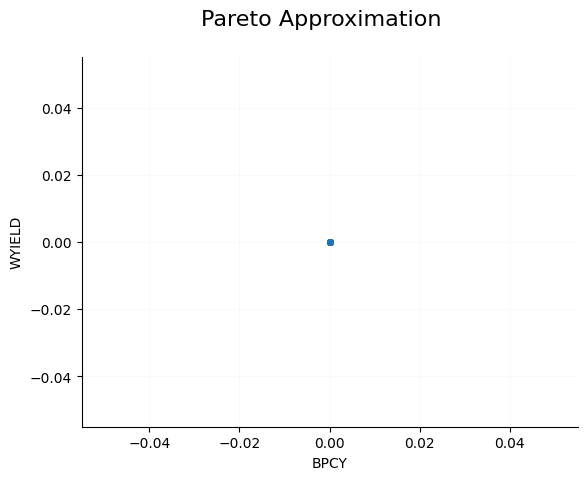

In [20]:
final_pop = ea.run()